### Open File

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('./data/df_features.gz')

I delete the rows without a distance to city center (because in the origin hotel don't have latitude and longitude)

In [3]:
df = df.dropna(subset=['Dist_Center'])
# df = df.dropna(subset=['Reservation_ADR'])

### Create Predicted Category for final models (2 categories)

In [4]:
diff_hotels = df[['Hotel_Address','Diff']].groupby('Hotel_Address').describe()
diff_hotels = diff_hotels.Diff.reset_index()

In [5]:
df = pd.merge(df, diff_hotels, on='Hotel_Address')

In [6]:
category = np.array(['Bad' if i < 7 else 'Good' for i in df.Reviewer_Score])
df.loc[:, 'Category'] = category
df.Category.value_counts() / len(df) 

Good    0.831582
Bad     0.168418
Name: Category, dtype: float64

In [7]:
df.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score',
       'days_since_review', 'lat', 'lng', 'Diff', 'Diff_Percentage',
       'Review_Month', 'Review_Year', 'Country', 'City', 'Pet', 'Purpose',
       'Whom', 'Room', 'Length', 'Device', 'Room_Recode', 'Nationality_Recode',
       'Length_Recode', 'Close_Landmarks', 'Dist_Center', 'Dist_Airport',
       'Dist_Train', 'Price', 'Stars', 'Length_N', 'Reservation_ADR',
       'food_Neg', 'staff_Neg', 'location_Neg', 'value_Neg', 'comfort_Neg',
       'room_Neg', 'facilities_Neg', 'cleanliness_Neg', 'food_Pos',
       'staff_Pos', 'location_Pos', 'value_Pos', 'comfort_Pos', 'room_Pos',
       'facilities_Pos', 'cleanliness_Pos', 'food_Neg_Hotel',
       'staff_Neg_Hotel', 'loca

### Balance Nationalities and / or Categories

In [8]:
def balance_df(Balance_Nationality, Balance_Category):
    df_balance_country = df.copy()
    if Balance_Nationality:
        df_balance_country = None
        for i in list(df.Nationality_Recode.value_counts().index):
            nationality = df[df.Nationality_Recode == i]
            n = 20000
            if len(nationality) < 20000:
                n = len(nationality)
            nationality = nationality.sample(n, random_state=1)
            df_balance_country = pd.concat([df_balance_country, nationality])
    
    df_balance_class = df_balance_country.copy()
    if Balance_Category:
        df_balance_class = None
        minclass = np.min(df_balance_country.Category.value_counts())
        classes = list(df_balance_country.Category.value_counts().index)
        for i in classes:
            selected_class = df_balance_country[df_balance_country.Category == i].sample(minclass, random_state=1)
            df_balance_class = pd.concat([df_balance_class, selected_class])
    
    return(df_balance_class)

In [9]:
df_balanced = balance_df(Balance_Nationality=True, Balance_Category=True)

### Prepare Data to run Models

In [533]:
df_model = df_balanced.sample(n=20000, random_state=1)

In [534]:
x_categorical = ['Review_Month', 'City', 'Pet', 'Purpose', 'Whom', 'Room_Recode', 'Nationality_Recode', 'Length_Recode',
                 'Stars']
x_numerical = ['Total_Number_of_Reviews_Reviewer_Has_Given', 'food_Neg_Hotel','staff_Neg_Hotel', 'location_Neg_Hotel', 
               'value_Neg_Hotel','comfort_Neg_Hotel', 'room_Neg_Hotel', 'facilities_Neg_Hotel','cleanliness_Neg_Hotel', 
               'food_Pos_Hotel', 'staff_Pos_Hotel','location_Pos_Hotel', 'value_Pos_Hotel', 'comfort_Pos_Hotel',
               'room_Pos_Hotel', 'facilities_Pos_Hotel', 'cleanliness_Pos_Hotel','count', 'mean', 'std', 'min', '25%', 
               '50%', '75%', 'max']
x_col = x_categorical + x_numerical
y_col = 'Category'

In [535]:
X_numerical = df_model[x_numerical]
X_numerical_std = X_numerical.apply(lambda x: ((x-np.mean(x)) / np.std(x)))

In [536]:
X_categorical = pd.get_dummies(df_model[x_categorical], prefix_sep='_', drop_first=True)
X_categorical = X_categorical.fillna('Not Available')

In [537]:
X = pd.concat([X_numerical_std, X_categorical], axis=1, sort=False)
y = df_model[y_col]

Split into Train and Test

In [538]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=100)

In [539]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((10000, 62), (10000,), (10000, 62), (10000,))

## MODELS

### Evaluate Model

In [540]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB

from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, f1_score, precision_score, recall_score

In [541]:
def evaluate(model):
    clf = model
    clf.fit(X_train, y_train)
    train = clf.predict(X_train)
    pred = clf.predict(X_test)
    print('Test :', f'{accuracy_score(pred, y_test):.4f}', '|', f'{cohen_kappa_score(pred, y_test):.4f}')
    print('Train:', f'{accuracy_score(train, y_train):.4f}', '|', f'{cohen_kappa_score(train, y_train):.4f}')
    return(pred)

### KNN

In [542]:
pred_knn = evaluate(KNeighborsClassifier(n_neighbors=5))

Test : 0.6036 | 0.2074
Train: 0.7271 | 0.4539


### Gradient Boosted Trees

In [543]:
pred_gbt = evaluate(GradientBoostingClassifier(learning_rate=0.04, max_depth=3, random_state=1))

Test : 0.6516 | 0.3033
Train: 0.6733 | 0.3465


### Random Forest

In [544]:
pred_rf = evaluate(RandomForestClassifier(n_estimators = 75, max_depth = 5, random_state=1))

Test : 0.6480 | 0.2959
Train: 0.6620 | 0.3248


### XGBoosting

In [545]:
pred_xgb = evaluate(xgb.XGBClassifier(objective="binary:logistic", n_estimators = 7, max_depth=4, random_state=1))

Test : 0.6517 | 0.3035
Train: 0.6713 | 0.3425


### Logistic Regresion

In [546]:
pred_log = evaluate(LogisticRegression(solver='lbfgs', max_iter=500, random_state=1))

Test : 0.6560 | 0.3122
Train: 0.6635 | 0.3262


### Decision Trees

In [547]:
pred_tree = evaluate(DecisionTreeClassifier(max_depth=4, random_state=1))

Test : 0.6416 | 0.2838
Train: 0.6493 | 0.2962


### SVM

In [548]:
pred_svm = evaluate(SVC(C=0.5, random_state=1))

Test : 0.6526 | 0.3053
Train: 0.6686 | 0.3370


### Naive Bayes

In [549]:
pred_nb = evaluate(BernoulliNB())

Test : 0.6452 | 0.2906
Train: 0.6389 | 0.2774


### Models Summary

In [550]:
df_models_test = pd.DataFrame(list(zip(y_test, pred_log, pred_knn, pred_xgb, pred_gbt, pred_rf, 
                                       pred_svm, pred_tree, pred_nb)), 
                         columns=['TEST','logistic','knn','xgb','gbt','rf','svm', 'tree', 'nb']) 
df_models_test.head()

,TEST,logistic,knn,xgb,gbt,rf,svm,tree,nb
0,Good,Bad,Bad,Bad,Bad,Bad,Bad,Good,Bad
1,Bad,Bad,Good,Bad,Bad,Bad,Bad,Bad,Good
2,Bad,Bad,Good,Bad,Bad,Bad,Bad,Bad,Bad
3,Good,Good,Good,Good,Good,Bad,Good,Good,Bad
4,Bad,Good,Good,Good,Good,Good,Good,Good,Good


## ENSEMBLE

In [551]:
modelos = [('Logistic', LogisticRegression(solver='lbfgs', max_iter=1500, random_state=1)), 
           ('Random Forest', RandomForestClassifier(n_estimators = 70, max_depth = 5, random_state=1)),
           ('XGB', xgb.XGBClassifier(objective="binary:logistic", n_estimators = 7, max_depth=4, random_state=1)),
           ('GBT', GradientBoostingClassifier(learning_rate=0.04, max_depth=3, random_state=1))
          ]

pred = pd.DataFrame(columns=['Logistic','Random Forest','XGB','GBT'])
prob = pd.DataFrame(columns=['Logistic','Random Forest','XGB','GBT'])

for i in modelos:
    clf = i[1]
    clf.fit(X_train, y_train)
    train_ens = clf.predict(X_train)
    pred_ens = clf.predict(X_test)
    prob_ens = clf.predict_proba(X_test)

    pred[i[0]] = pred_ens
    prob[i[0]] = prob_ens[:,0]

print('Done!')

Done!


In [552]:
prob_final = prob.apply(lambda x: np.mean(x), axis=1)
prob_final = ['Good' if i < 0.5 else 'Bad' for i in prob_final]
print('Probability :',  
      f'{accuracy_score(prob_final, y_test):.4f}', '|', 
      f'{cohen_kappa_score(prob_final, y_test):.4f}'
     )

Probability : 0.6540 | 0.3081


## STACKING

Predictions using Random Forest adding the predicions of other models to the original dataset.
I had to split the test set in 2 to create the new train/test set, otherwise i fall into overfitting because my original training set is biased vs the test set

First I append the predictions of the model to the dataset

In [553]:
X_2 = X_test.copy()
y_2 = y_test.copy()

In [554]:
X_2['logistic'] = pred_log
X_2['gbt'] = pred_gbt
X_2['knn'] = pred_knn
X_2['svm'] = pred_svm
X_2['tree'] = pred_tree
X_2['xgb'] = pred_xgb
X_2['nb'] = pred_nb
X_2['rf'] = pred_rf

In [555]:
X_2.iloc[:,-8:].head(2)

,logistic,gbt,knn,svm,tree,xgb,nb,rf
508691,Bad,Bad,Bad,Bad,Good,Bad,Bad,Bad
249556,Bad,Bad,Good,Bad,Bad,Bad,Good,Bad


In [556]:
X_2.iloc[:,-8:] = X_2.iloc[:,-8:].apply(lambda x: [1 if i=='Good' else 0 for i in x])

In [557]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=100)

### Stacked Model

In [558]:
models = [('Random Forest', RandomForestClassifier(n_estimators = 75, max_depth = 5, random_state=1)), 
          ('XGB', xgb.XGBClassifier(objective="binary:logistic", n_estimators = 2, max_depth=4, random_state=1)),
          ('GBT', GradientBoostingClassifier(learning_rate=0.005, max_depth=3, random_state=1)),
          ('Logistic', LogisticRegression(solver='lbfgs', max_iter=1000, random_state=1)),
          ('SVM', SVC(C=0.5, random_state=1))
         ]

for i in models:
    clf = i[1]
    clf.fit(X_train_2, y_train_2)
    train_stck_2 = clf.predict(X_train_2)
    pred_stck_2 = clf.predict(X_test_2)
    print(i[0])
    print('Test :',f'{accuracy_score(pred_stck_2, y_test_2):.4f}', '|',f'{cohen_kappa_score(pred_stck_2, y_test_2):.4f}')
    print('Train:',f'{accuracy_score(train_stck_2, y_train_2):.4f}', '|',f'{cohen_kappa_score(train_stck_2, y_train_2):.4f}')
    print('----------------------')

Random Forest
Test : 0.6630 | 0.3262
Train: 0.6669 | 0.3338
----------------------
XGB
Test : 0.6605 | 0.3213
Train: 0.6629 | 0.3257
----------------------
GBT
Test : 0.6635 | 0.3277
Train: 0.6562 | 0.3122
----------------------
Logistic
Test : 0.6700 | 0.3404
Train: 0.6562 | 0.3125
----------------------
SVM
Test : 0.6600 | 0.3201
Train: 0.6595 | 0.3191
----------------------


Reserva = 0.58
Distancia = 0.61
Avg.Score = 0.64
Hotel = 0.65
Describe = 0.65

Hotel + Describe = 0.65x
Hotel + Distancia = 0.65
Hotel + Avg.Score = 0.65
Hotel + Reserva = 0.66

Describe + Reserva  = 0.66
Describe + Distancia = 0.65
Describe + Avg.Score = 0.66

Avg.Score + Reserva = 0.67
Avg.Score + Distancia = 0.64x

Describe + Reserva + Hotel = 0.67
Avg.Score + Reserva + Hotel = 0.66x
Avg.Score + Reserva + Describe = 0.66
Avg.Score + Distancia + Hotel = 0.66
Reserva + Describe + Distancia  = 0.65x

#### Backward Elimination

In [561]:
import random
from random import sample

In [562]:
def check_model(variable, X_train, X_test, y_train, y_test):
    clf = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=1)    
    clf.fit(X_train, y_train)
    prediccion = clf.predict(X_test)
    acc_score = accuracy_score(prediccion, y_test)
    f1 = f1_score(prediccion, y_test, pos_label='Bad')
    return(variable, acc_score, f1)

In [565]:
def try_seed(seed, verbose=False):
    score = check_model('', X_train_2, X_test_2, y_train_2, y_test_2)[1]
    varout = []
    varin = list(X_test_2.columns)

    for n in range(len(varin)):
        max_score = score
        max_feature = []
        random.seed(seed)
        
        for i in sample(varin, len(varin)):
            var_test = varin.copy()
            var_test.remove(i)
            X_train_vartest = X_train_2[var_test]
            X_test_vartest = X_test_2[var_test]
            check = check_model(i, X_train_vartest, X_test_vartest, y_train_2, y_test_2)
            if check[1] > max_score:
                max_feature = check[0]
                max_score = check[1] 
                varin.remove(max_feature)   
                varout.append(max_feature)
                if verbose:
                    print('{0:0=2d}'.format(n), 'Original Score:', f'{score:.4f}', '| New score:', f'{max_score:.4f}', 
                          '| Variable to remove:', max_feature)
                break

        if max_score > score:
            score = max_score
        else:
            print('Seed:',seed, '<-', score)
            return(varin, score)
            break

In [566]:
max_score = 0
varin = []
for seed in range(20):
    vartest, score = try_seed(seed)
    if score > max_score:
        max_score = score
        varin = vartest

Seed: 0 <- 0.6795
Seed: 1 <- 0.683
Seed: 2 <- 0.6785
Seed: 3 <- 0.677
Seed: 4 <- 0.673
Seed: 5 <- 0.678
Seed: 6 <- 0.682
Seed: 7 <- 0.682
Seed: 8 <- 0.68
Seed: 9 <- 0.6815
Seed: 10 <- 0.6785
Seed: 11 <- 0.6815
Seed: 12 <- 0.678
Seed: 13 <- 0.6795
Seed: 14 <- 0.6815
Seed: 15 <- 0.6755
Seed: 16 <- 0.6815
Seed: 17 <- 0.692
Seed: 18 <- 0.678
Seed: 19 <- 0.6815


In [573]:
len(varin), len(X_test_2.columns)

(50, 70)

In [595]:
X_train_varin = X_train_2[varin]
X_test_varin = X_test_2[varin]
clf = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=1)  
clf.fit(X_train_varin, y_train_2)
prediction = clf.predict(X_test_varin)
probability = clf.predict_proba(X_test_varin)

(array([ 27.,  50.,  58.,  89., 105., 120., 114., 157., 137., 150., 138.,
        134., 144., 165., 121.,  95.,  85.,  60.,  42.,   9.]),
 array([0.06931097, 0.11124704, 0.15318311, 0.19511918, 0.23705525,
        0.27899132, 0.32092739, 0.36286346, 0.40479953, 0.4467356 ,
        0.48867167, 0.53060774, 0.57254381, 0.61447988, 0.65641595,
        0.69835202, 0.74028809, 0.78222416, 0.82416023, 0.8660963 ,
        0.90803237]),
 <a list of 20 Patch objects>)

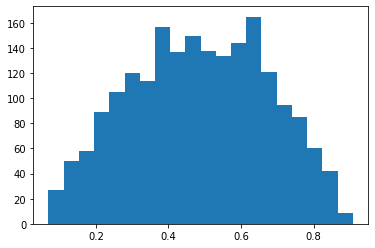

In [596]:
plt.hist(probability[:,1], bins=20)

In [597]:
pd.crosstab(prediction, y_test_2)

Category,Bad,Good
row_0,,
Bad,709,336
Good,280,675


In [598]:
print(f'{accuracy_score(prediction, y_test_2):.4f}', '<- Accuracy')
print(f'{cohen_kappa_score(prediction, y_test_2):.4f}', '<- Kappa')
print(f'{f1_score(prediction, y_test_2, pos_label="Bad"):.4f}', '<- F1')

0.6920 <- Accuracy
0.3843 <- Kappa
0.6971 <- F1


#### F1 analysis

In [574]:
prob_bad = probability[:,0]
for thr in np.arange(0.4, 0.6, 0.01):
    classification = ['Bad' if i > thr else 'Good' for i in prob_bad]
    accuracy = accuracy_score(classification, y_test_2)
    kappa = cohen_kappa_score(classification, y_test_2)
    f1 = f1_score(classification, y_test_2, pos_label='Bad')
    avg =np.mean([accuracy, f1])
    print('Threshold:', f'{thr:.2f}', '| Accuracy:', f'{accuracy:.4f}', '| Kappa:', f'{kappa:.4f}', '| F1:', f'{f1:.4f}', 
          '| Avg:', f'{avg:.4f}')

Threshold: 0.40 | Accuracy: 0.6515 | Kappa: 0.3059 | F1: 0.7050 | Avg: 0.6783
Threshold: 0.41 | Accuracy: 0.6590 | Kappa: 0.3205 | F1: 0.7070 | Avg: 0.6830
Threshold: 0.42 | Accuracy: 0.6590 | Kappa: 0.3203 | F1: 0.7030 | Avg: 0.6810
Threshold: 0.43 | Accuracy: 0.6625 | Kappa: 0.3270 | F1: 0.7009 | Avg: 0.6817
Threshold: 0.44 | Accuracy: 0.6650 | Kappa: 0.3318 | F1: 0.6998 | Avg: 0.6824
Threshold: 0.45 | Accuracy: 0.6695 | Kappa: 0.3405 | F1: 0.6994 | Avg: 0.6845
Threshold: 0.46 | Accuracy: 0.6690 | Kappa: 0.3393 | F1: 0.6944 | Avg: 0.6817
Threshold: 0.47 | Accuracy: 0.6735 | Kappa: 0.3480 | F1: 0.6936 | Avg: 0.6835
Threshold: 0.48 | Accuracy: 0.6750 | Kappa: 0.3508 | F1: 0.6908 | Avg: 0.6829
Threshold: 0.49 | Accuracy: 0.6810 | Kappa: 0.3625 | F1: 0.6912 | Avg: 0.6861
Threshold: 0.50 | Accuracy: 0.6920 | Kappa: 0.3843 | F1: 0.6971 | Avg: 0.6946
Threshold: 0.51 | Accuracy: 0.6855 | Kappa: 0.3711 | F1: 0.6853 | Avg: 0.6854
Threshold: 0.52 | Accuracy: 0.6785 | Kappa: 0.3568 | F1: 0.6728 